<a href="https://colab.research.google.com/github/claredavies/ImageIndexing/blob/master/Image_Indexing_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [ ]:
NAME  = "Clare Davies"
DNI   = "99999999R"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd drive/MyDrive/ImageIndexing

/content/drive/MyDrive/ImageIndexing


Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [ ]:
!unzip iric_dev_kit.zip

Archive:  iric_dev_kit.zip
replace iric_dev_kit/iric.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_dev_kit.iric_utils.eval_holidays as ev
import iric_dev_kit.iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will implement and evaluate different methods for indexing images. As usual during this course, we will use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. **Check the Assignment 1 to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **mean average precision** (mAP) over all queries. **Check also the Assignment 1 to remember how to use this script and the different functions it offers.**

### Loading images
As we did in Assignment 1, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In this assignment, we will use the original holidays dataset:

In [ ]:
!unzip holidays_mini.zip

In [ ]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

# with open('../holidays/holidays_images.dat') as f:

with open('holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        # img = cv2.imread('../holidays/images/' + imname)

        img = cv2.imread('holidays_mini/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

19
31


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

Unlike in Assigment 1, now you will be provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. First, download the descriptors from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/Eam8Ld8YDaJAhNr91YVdAZIB_wVZJ8kzzKD7BR6R3LziMw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Now, a new directory called `siftgeo` should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [ ]:
import tarfile
def unzip_tarfile(filename):
  try:
    tar = tarfile.open(filename)
    tar.extractall()
    tar.close()
  except EOFError:
    print("error")

In [ ]:
unzip_tarfile("siftgeo.tar.gz")

In [ ]:
%cd iric_dev_kit

/content/drive/MyDrive/ImageIndexing/iric_dev_kit


In [ ]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

19
31
19
31
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## $k$-d trees and LSH 
Let's start coding. At this section, you will develop a retrieval system using $k$-d trees and Locality Sensitive Hashing (LSH). 

### General framework
As we did in the first assignment, you first will develop some utilities to simplify your work. Write a function called `search_image` to search an image in a generic index (database). You should search each descriptor of the given query image and obtain its two closest SIFT descriptors in the database. Next, the initial set of matches should be filtered using the **NNDR criterion (use 0.8 as ratio)**, as you did in the previous assignment. For each database image, its final score with regard to this query image will be the **number of correct matches** with this image:

The 2 matches returned have 0 distance!



In [53]:
def search_image(descs, index, id_to_name):
    """
    Search an image in the index
    
    - descs: A numpy array. This is the set descriptors extracted from the query image
    - index: OpenCV FLANN index to search for descriptors.
    - id_to_name: An associative list to link every image index to its real name
        e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
  
    """

    for desc in descs:
      # Perform FLANN-based matching to find similar descriptors
      matches = index.knnMatch(queryDescriptors=descs, k=2)

    # print("matches: ", matches)
    # print("matches len: ", len(matches))

    # Apply ratio test to filter out bad matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good_matches.append(m)
    
    # Collect indices of similar images
    similar_ids = set()
    for m in good_matches:
        img_idx = m.imgIdx
        similar_ids.add(img_idx)
    
    # Convert indices to image names
    similar_names = []
    for id in similar_ids:
        similar_names.append(id_to_name[id])
    
    # Return ordered list of similar images
    return sorted(similar_names)

In [ ]:
print(train_names[0:2])

['100001.jpg', '100002.jpg']


In [ ]:
print(query_names[0])

100000.jpg


Now, write a function called `compute_mAP`. Given a list of query images and a trained index, this function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [ ]:
print(query_desc[0])

In [ ]:
ground_truth = {}
with open('../holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
    
        # Checking if this is a query image
        if imno % 100 == 0:
            results = []
            ground_truth[imname] = results
        else:
            results.append(imname)
print(ground_truth)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100101.jpg'], '100200.jpg': ['100201.jpg'], '100300.jpg': ['100301.jpg', '100302.jpg'], '100400.jpg': ['100401.jpg'], '100500.jpg': ['100501.jpg', '100502.jpg', '100503.jpg'], '100600.jpg': ['100601.jpg'], '100700.jpg': ['100701.jpg'], '100800.jpg': ['100801.jpg'], '100900.jpg': ['100901.jpg', '100902.jpg'], '101000.jpg': ['101001.jpg'], '101100.jpg': ['101101.jpg'], '101200.jpg': ['101201.jpg'], '101300.jpg': ['101301.jpg'], '101400.jpg': ['101401.jpg', '101402.jpg', '101403.jpg', '101404.jpg'], '101500.jpg': ['101501.jpg', '101502.jpg', '101503.jpg', '101504.jpg'], '101600.jpg': ['101601.jpg'], '101700.jpg': ['101701.jpg', '101702.jpg'], '101800.jpg': ['101801.jpg']}


In [ ]:
def compute_mAP(query_names, query_desc, index, id_to_name, gt_file):
    """
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of the query images
    - query_desc: A list containing numpy arrays of size (ndesc_for_this_image, 128)
                  Each numpy array i corresponds to the descriptors found at image i
    - index: FLANN index
    - id_to_name: An associative array to link every image index to its real name
                  e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, an sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    total_results = {}
    m_ap = 0.0
      
    # search_results = [list(zip(search_image(query_img)))[1] for query_img in query_imgs] 

    for qname, qdesc in zip(query_names, query_desc):
        # Search for similar images
        results = search_image(qdesc, index, id_to_name)
        total_results[qname] = results
    
    m_ap = ev.compute_mAP(total_results, gt_file)
    return total_results, m_ap

### $k$-d Trees
In this section you will use a set of randomized $k$-d trees to index the database of images. Write a function called `build_db_kdtrees` to build a set of randomized $k$-d trees given a set of descriptors:

> **Useful links**: [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.5/dc/de2/classcv_1_1FlannBasedMatcher.html), [Possible algorithms to create an index](https://docs.opencv.org/4.5.5/db/d18/classcv_1_1flann_1_1GenericIndex.html#a8fff14185f9f3d2f2311b528f65b146c), [Algorithms IDs](https://github.com/opencv/opencv/blob/master/modules/flann/include/opencv2/flann/defines.h#L70)

In [ ]:
def build_db_kdtrees(descs, ntrees = 4):
    """
    Build a set of randomized k-d trees.
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train
  
    RETURN: 
    - index: Trained FLANN index
    """  
  
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=ntrees)
    search_params = dict(checks=32)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann.add(descs)
    flann.train()
    return flann

Checking to make sure when pass in all train_desc that it not just matching to all of them

In [ ]:
index = build_db_kdtrees(train_desc)
print(len(index.getTrainDescriptors()))
img_res = search_image(query_desc[0], index, train_names)
print(img_res)
print("number of training images to match to: ", len(train_names))
print("number of training images actually matched to: ", len(img_res))

31
['100002.jpg', '100101.jpg', '100201.jpg', '100502.jpg', '100503.jpg', '101503.jpg', '101504.jpg']
number of training images to match to:  31
number of training images actually matched to:  7


In [ ]:
# Simple example of DB construction
index = build_db_kdtrees(train_desc[0:2])
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2], '../holidays_mini/holidays_images.dat')
print(mAP) # This should be 0 now, since there is only two images in the database.

0.05263157894736842


In [ ]:
def plot_chart(values, labels, title, xlabel, ylabel):
  fig, ax = plt.subplots()
  ax.bar(labels, values)

  # Set the chart title and axis labels
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  # Display the chart
  plt.show()

**Q1**: Using functions developed so far, in the following cell compute the resulting **mAP** of the system **using 4 trees**: (the default values)

In [76]:
import time

start_time = time.time()
index = build_db_kdtrees(train_desc, ntrees = 4)
train_time_kdtrees = time.time() - start_time

In [ ]:
img_res = search_image(query_desc[0], index, train_names)
results_4_trees, mAP_kdtree_4_trees = compute_mAP(query_names, query_desc, index, train_names, '../holidays_mini/holidays_images.dat')
print('mAP: %.5f' % mAP_kdtree_4_trees)

**Q2**: Are the results stable? Do you obtain always the same mAP? Why?

In [ ]:
_, mAP_kdtree_4_trees_attempt1 = compute_mAP(query_names, query_desc, index, train_names, '../holidays_mini/holidays_images.dat')

_, mAP_kdtree_4_trees_attempt2 = compute_mAP(query_names, query_desc, index, train_names, '../holidays_mini/holidays_images.dat')

_, mAP_kdtree_4_trees_attempt3 = compute_mAP(query_names, query_desc, index, train_names, '../holidays_mini/holidays_images.dat')

In [ ]:
print("different mAPs for the same query: ", mAP_kdtree_4_trees_attempt1, mAP_kdtree_4_trees_attempt2, mAP_kdtree_4_trees_attempt3)

different mAPs for the same query:  0.5195977633477634 0.5195977633477634 0.5195977633477634


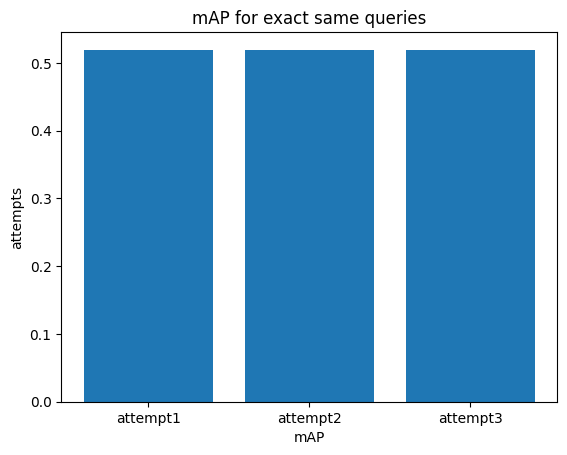

In [ ]:
values = [mAP_kdtree_4_trees_attempt1, mAP_kdtree_4_trees_attempt2, mAP_kdtree_4_trees_attempt3]
labels = ["attempt1", "attempt2", "attempt3"]
plot_chart(values, labels, "mAP for exact same queries", "mAP", "attempts")

**Q3:** Analyze the effect of changing the number of trees in terms of mAP and average response time. Some plots here can be useful to justify your answer.

In [ ]:
index = build_db_kdtrees(train_desc[0:5], ntrees = 2)
img_res = search_image(query_desc[0], index, train_names[0:5])
results, mAP_kdtree2 = compute_mAP(query_names, query_desc, index, train_names[0:5], '../holidays_mini/holidays_images.dat')
print("mAP with 2 trees: ", mAP_kdtree2)

index = build_db_kdtrees(train_desc[0:5], ntrees = 4)
img_res = search_image(query_desc[0], index, train_names[0:5])
results, mAP_kdtree4 = compute_mAP(query_names, query_desc, index, train_names[0:5], '../holidays_mini/holidays_images.dat')
print("mAP with 4 trees: ", mAP_kdtree4)

index = build_db_kdtrees(train_desc[0:5], ntrees = 8)
img_res = search_image(query_desc[0], index, train_names[0:5])
results, mAP_kdtree8 = compute_mAP(query_names, query_desc, index, train_names[0:5], '../holidays_mini/holidays_images.dat')
print("mAP with 8 trees: ", mAP_kdtree8)

mAP with 2 trees:  0.12938596491228072
mAP with 4 trees:  0.10307017543859649
mAP with 8 trees:  0.13596491228070176


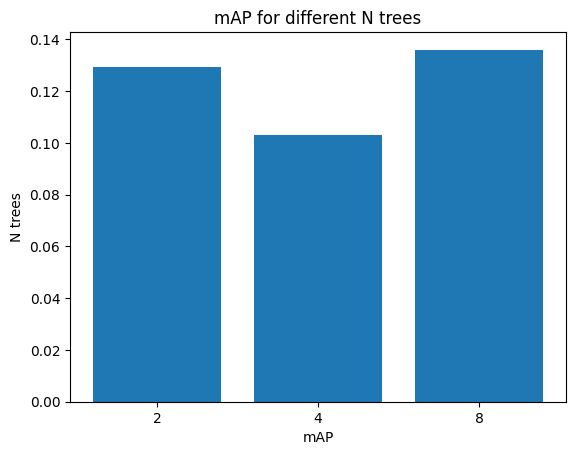

In [67]:
# Data for the bar chart
mAP_scores_kdtree = [mAP_kdtree2, mAP_kdtree4, mAP_kdtree8]
labels_kdtree = ['2', '4', '8']

plot_chart(mAP_scores_kdtree, labels_kdtree, "mAP for different N trees", "mAP", "N trees")

### Locality Sensitive Hashing (LSH)
In this section, you will use LSH to index the database of images. The LSH implementation included in OpenCV uses **bit sampling** for **Hamming distance** as a hash function and, therefore, binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images, but using, for instance, ORB.

In the following cell, write the code required to generate **roughly 1500 keypoints / descriptors** using ORB for each query / train image:

> **Useful links**: [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [54]:
def generateAllDescriptorsAndKeypoints(query_images, train_images, no_keypoints=1500, no_descriptors=1500):
    """
    In this section, you will use LSH to index the database of images. The LSH implementation 
    included in OpenCV uses bit sampling for Hamming distance as a hash function and, therefore, 
    binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images
    , but using, for instance, ORB.

    Useful links: cv2.ORB_create

    generate roughly 1500 keypoints / descriptors using ORB for each query / train image:
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train

    RETURN: 
    - query_kps_orb: list of keypoints for query images
    - query_desc_orb: list of descriptors for query images
    - train_kps_orb: list of keypoints for train images
    - train_desc_orb: list of descriptors for train images
    """ 
    
    orb = cv2.ORB_create(nfeatures=no_keypoints, nlevels=8, scoreType=cv2.ORB_FAST_SCORE)

    # Initialize keypoint and descriptor lists for query and train images
    query_kps_orb = []
    query_desc_orb = []
    train_kps_orb = []
    train_desc_orb = []

    # Generate keypoints and descriptors for query images
    for query_image in query_images:
      img = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
      kps, desc = orb.detectAndCompute(img, None)
      query_kps_orb.append(kps)
      query_desc_orb.append(desc)

    # Generate keypoints and descriptors for train images
    for train_image in train_images:
      img = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
      kps, desc = orb.detectAndCompute(img, None)
      train_kps_orb.append(kps)
      train_desc_orb.append(desc)

    return query_kps_orb, query_desc_orb, train_kps_orb, train_desc_orb

In [55]:
[query_kps_orb, query_desc_orb, train_kps_orb, train_desc_orb] = generateAllDescriptorsAndKeypoints(query_imgs, train_imgs)

In [56]:
# Show some data
print(len(query_kps_orb[0]))
print(query_desc_orb[0].shape)
print(query_desc_orb[0])

1563
(1563, 32)
[[ 45  45  17 ... 251  82 160]
 [ 13 220 255 ... 146  84 171]
 [203   4 103 ... 244 112 116]
 ...
 [211  13 119 ... 160 165 116]
 [224  98 157 ... 240 138  11]
 [162  43 172 ...  93  90 207]]



Next, write a function called `build_db_lsh` to build a **standard** (*no multi-probe*) LSH index from a set of images:

In [57]:
def build_db_lsh(descs, tables = 6, hash_size = 12):
    """
    build a standard (no multi-probe) LSH index from a set of images
    Index a set of images using LSH.    
    
    - descs: A list containing numpy arrays of size (~1500, 32). Each numpy array
        i corresponds to the ORB descriptors found at image i.
    - tables: Number of hash tables to create.
    - hash_size: Hash length in bits.
  
    RETURN: 
    - index: The trained LSH index.
    """  
    FLANN_INDEX_LSH = 6

    brisk = cv2.BRISK()

    index_params= dict(algorithm = FLANN_INDEX_LSH,
                      table_number = tables,
                      key_size = hash_size,    
                      multi_probe_level = 0)
    search_params = dict(checks=50) 

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    flann.add(descs)

    return flann

In [ ]:
print(train_desc_orb[0])

[[ 89  27 223 ... 224  33 113]
 [146 161 107 ... 130 171 169]
 [ 39  63 252 ... 223  71 245]
 ...
 [  3 141  39 ...   2 177 213]
 [ 41 203  17 ... 142 208 137]
 [116 106 233 ... 251  86 100]]


In [58]:
# Simple example of DB construction
index = build_db_lsh(train_desc_orb[0:2])
print(len(index.getTrainDescriptors()))

2


**Q4**: In the following cell compute the resulting **mAP** of the system **using 6 tables and a hash size of 12**: (the default values)

In [77]:
# Fill this variable with the resulting mAP
mAP_lsh = 0.0

start_time = time.time()
index = build_db_lsh(train_desc_orb[0:5])
train_time_lsh = time.time() - start_time

In [ ]:
img_res = search_image(query_desc_orb[0], index, train_names[0:5])
results, mAP_lsh = compute_mAP(query_names, query_desc_orb, index, train_names[0:5], '../holidays_mini/holidays_images.dat')

In [ ]:
print("results found: ", results)
print("ground truth: ", ground_truth)

results found:  {'100000.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100100.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100200.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100300.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100400.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100500.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100600.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100700.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100800.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '100900.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '101000.jpg': ['100001.jpg', '100002.jpg', '100101.jpg', '100201.jpg', '100301.jpg'], '101100.jpg': ['100001.jpg', '100002.

In [ ]:
print('mAP: %.5f' % mAP_lsh)

mAP: 0.08860


**Q5**: Are the results stable? Do you obtain always the same mAP? Why?

In [ ]:
_, mAP_lsh_attempt1 = compute_mAP(query_names, query_desc_orb, index, train_names[0:5], '../holidays_mini/holidays_images.dat')

_, mAP_lsh_attempt2 = compute_mAP(query_names, query_desc_orb, index, train_names[0:5], '../holidays_mini/holidays_images.dat')

_, mAP_lsh_attempt3 = compute_mAP(query_names, query_desc_orb, index, train_names[0:5], '../holidays_mini/holidays_images.dat')

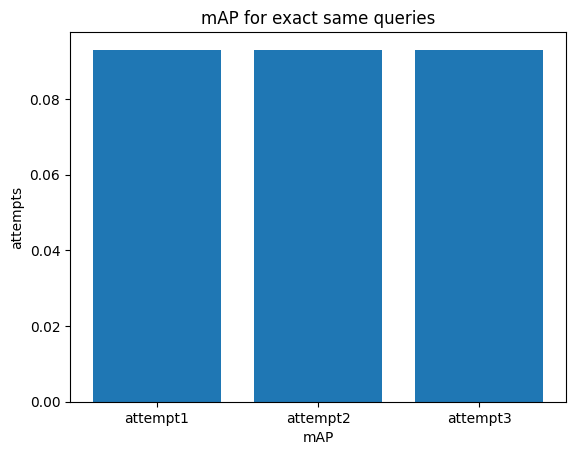

In [ ]:
values = [mAP_lsh_attempt1, mAP_lsh_attempt2, mAP_lsh_attempt3]
labels = ["attempt1", "attempt2", "attempt3"]
plot_chart(values, labels, "mAP for exact same queries", "mAP", "attempts")

**Q6**: Analyze the effect of changing the number of tables / hash size in terms of mAP and average response time. Some plots here can be useful to justify your answer.

In [ ]:
import time
index_table6_hash12 = build_db_lsh(train_desc_orb[0:5], tables = 6, hash_size = 12)
start_time = time.time()
_, mAP_lsh_table6_hash12 = compute_mAP(query_names, query_desc_orb, index_table6_hash12, train_names[0:5], '../holidays_mini/holidays_images.dat')
time_table6_hash12 = time.time() - start_time
print("time_table6_hash12 %s seconds: ", time_table6_hash12)

In [59]:
index_table3_hash6 = build_db_lsh(train_desc_orb[0:5], 3, 6)
start_time = time.time()
res, mAP_lsh_table3_hash6 = compute_mAP(query_names, query_desc_orb, index_table3_hash6, train_names[0:5], '../holidays_mini/holidays_images.dat')
time_table3_hash6 = time.time() - start_time
print("time_table3_hash6 %s seconds: ", time_table3_hash6)

time_table3_hash6 %s seconds:  739.9293558597565


In [60]:
index_table12_hash24 = build_db_lsh(train_desc_orb[0:5], 3, 6)
start_time = time.time()
res, mAP_lsh_table12_hash24 = compute_mAP(query_names, query_desc_orb, index_table12_hash24, train_names[0:5], '../holidays_mini/holidays_images.dat')
time_table12_hash24 = time.time() - start_time
print("time_table12_hash24 %s seconds: ", time_table12_hash24)

time_table12_hash24 %s seconds:  736.8589413166046


In [64]:
# Data for the bar chart
mAP_scores_hash = [mAP_lsh_table3_hash6, mAP_lsh_table6_hash12, mAP_lsh_table12_hash24]
time_scores_hash = [time_table3_hash6, time_table6_hash12, time_table12_hash24]
labels_hash = ['table3_hash6','table6_hash12','table12_hash24']

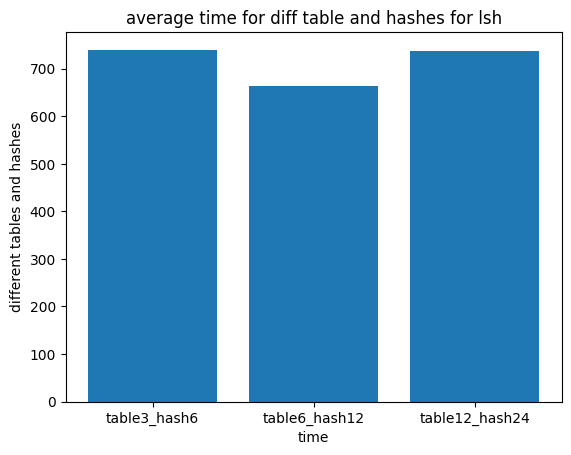

In [84]:
plot_chart(time_scores_hash, labels_hash, "average time for diff table and hashes for lsh", "time", "different tables and hashes")

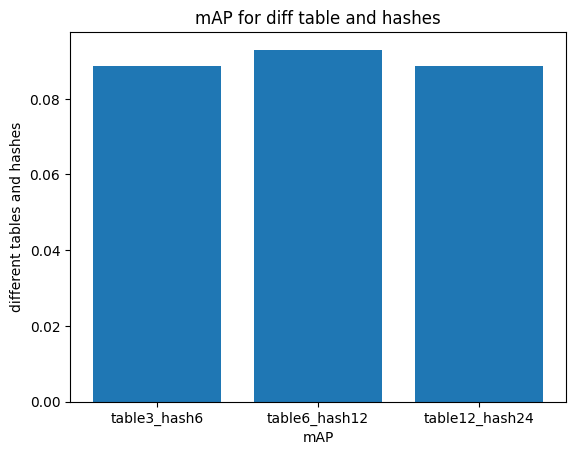

In [66]:
plot_chart(mAP_scores_hash, labels_hash, "mAP for diff table and hashes", "mAP", "different tables and hashes")

**Q7:** Despite the different descriptors used, compare the performance of the randomized k-d trees and LSH approaches from different points of view (accuracy, training times, querying times, ...). Some plots can be useful here to justify your answer.

Comparison via mAP

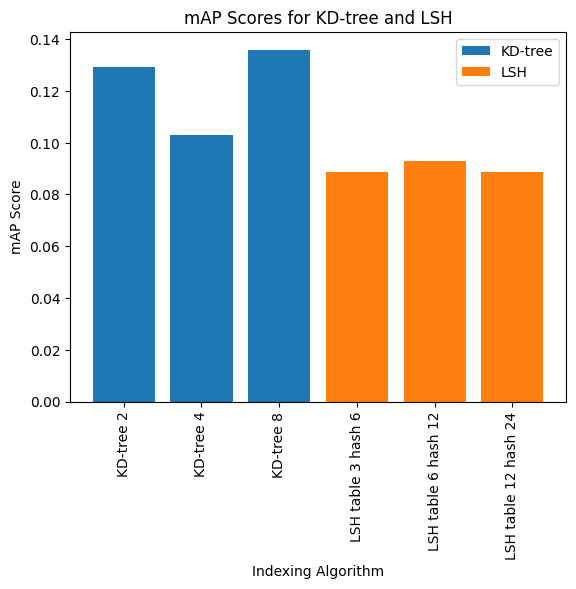

In [72]:
# Define x-axis labels
x_labels = ['KD-tree 2', 'KD-tree 4', 'KD-tree 8', 'LSH table 3 hash 6', 'LSH table 6 hash 12', 'LSH table 12 hash 24']

# Define mAP scores for KD-tree and LSH
mAP_scores_kdtree = [mAP_kdtree2, mAP_kdtree4, mAP_kdtree8]
mAP_scores_hash = [mAP_lsh_table3_hash6, mAP_lsh_table6_hash12, mAP_lsh_table12_hash24]

# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(x_labels[:3], mAP_scores_kdtree, label='KD-tree')
ax.bar(x_labels[3:], mAP_scores_hash, label='LSH')

# Set the chart title, axis labels, and legend
ax.set_title('mAP Scores for KD-tree and LSH')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('mAP Score')
ax.legend()

Comparison via Train times

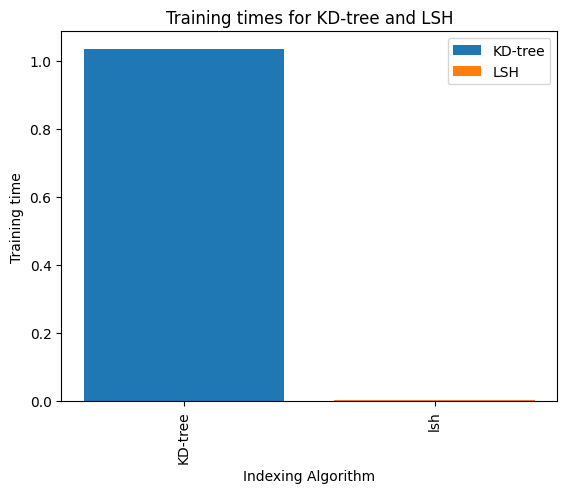

In [83]:
# Define x-axis labels
x_labels = ['lsh', 'KD-tree']

# Define mAP scores for KD-tree and LSH
training_time_lsh = [train_time_lsh]
training_time_kdtree = [train_time_kdtrees]

# Create a bar chart with both sets of mAP scores
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.bar(x_labels[1:], training_time_kdtree, label='KD-tree')
ax.bar(x_labels[:1], training_time_lsh, label='LSH')

# Set the chart title, axis labels, and legend
ax.set_title('Training times for KD-tree and LSH')
ax.set_xlabel('Indexing Algorithm')
ax.set_ylabel('Training time')
ax.legend()

## Bag-of-Words
In this section, you will implement the Bag-of-Words (BoW) model for image retrieval. Additionally, you will also implement the TF-IDF scoring scheme.

### Download visual dictionaries
To use a BoW model, first we need a visual vocabulary. The authors of the INRIA Holidays dataset provide some visual vocabularies, trained using a clustering method (e.g. $k$-means) in a different dataset (Flickr60K).

First, download these vocabularies from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/EY1G011OvfJOnwqWQQzmHmgBkXhLHBaK00wdizsUT252dw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

A folder named `clust` is now available in your workspace, containing visual vocabularies of 100, 200, 500, 1K, 2K, 5K, 10K, 20K, 50K, 100K and 200K visual words. Again, these are binary files, and therefore we provide you with functions to load and index them:

In [ ]:
%cd '../'

/content/drive/MyDrive/ImageIndexing


In [ ]:
unzip_tarfile("clust.tar.gz")

In [ ]:
voc = rd.load_visual_vocab("clust/clust_flickr60_k200.fvecs", ntrees=4)

With this function, the corresponding vocabulary is read. Additionally, a FLANN index structure based on kd-trees is built and returned using the centroids. This is to allow a fast access when searching for the closest visual words in the vocabulary. More precisely, in this example, 4 trees are constructed using the vocabulary of 200 centroids. Now, given a query descriptor(s), you can use `match` or `knnMatch` methods as usual to search for the closest (approximate) visual word(s) in the vocabulary.

### BoW and Inverted File
Now, write a class called `BoW` to manage the indexing procedure. This class should make use, in addition to the visual vocabulary, an inverted file to compute similarity scores between images. Apart from the class constructor, write three methods: `build_db`, `search_image` and `compute_mAP`:

In [ ]:
class BoW:
    """
    Class to implement the BoW model + Inverted File + TF-IDF Scoring scheme
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        vocab -  An OpenCV2 FLANN index based on a set of kd-trees
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}    
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently.

        - self.vocab: An OpenCV2 FLANN index based on a set of kd-trees
        - self.inv_list: the inverted file structure

        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays of SIFT descriptors which are not equal shape to Flann kd-trees. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        for i in range(len(img_names)):
            img_desc = img_descs[i]
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1

            bow_hist /= len(img_desc)
            self.tfidf[img_names[i]] = bow_hist

            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    if img_names[i] not in self.inv_list[word_id]:
                        self.inv_list[word_id][img_names[i]] = 1
                    else:
                        self.inv_list[word_id][img_names[i]] += 1

    def search_image(self, descs):
        """
        Search an image in the index. Use the TF-IDF here when scoring the images.
        - self.vocab: An OpenCV2 FLANN index based on a set of kd-trees
        - self.inv_list: the inverted file structure

        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """

        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)

        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1

        bow_hist /= len(descs)

        # Compute the TF-IDF score for each image in the index
        scores = {}
        for word_id, word_count in enumerate(bow_hist):
            if word_count == 0:
                continue
            for image_id, idf in self.inv_list[word_id].items():
                if image_id not in scores:
                    scores[image_id] = 0
                scores[image_id] += word_count * idf

        sorted_images = sorted(scores, key=scores.get, reverse=True)
        return sorted_images
      
    def compute_mAP(self, query_names, query_descs, gt_file):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
          
        for qname, qdesc in zip(query_names, query_desc):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results
        
        m_ap = ev.compute_mAP(total_results, gt_file)
        return total_results, m_ap

In [ ]:
# Example of use
index = BoW('clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:14], train_desc[0:14])
res = index.search_image(query_desc[5])
print(res)

['100201.jpg', '100503.jpg', '100801.jpg', '100501.jpg', '100502.jpg', '100001.jpg', '100401.jpg', '100301.jpg', '100302.jpg', '100101.jpg', '100601.jpg', '100701.jpg', '100901.jpg', '100002.jpg']


In [ ]:
results, mAP = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')
print(results)
print(mAP)

{'100000.jpg': ['100801.jpg', '100201.jpg', '100001.jpg', '100503.jpg', '100401.jpg', '100501.jpg', '100502.jpg', '100301.jpg', '100302.jpg', '100101.jpg', '100601.jpg', '100701.jpg', '100901.jpg', '100002.jpg'], '100100.jpg': ['100801.jpg', '100101.jpg', '100201.jpg', '100502.jpg', '100001.jpg', '100501.jpg', '100601.jpg', '100401.jpg', '100503.jpg', '100301.jpg', '100302.jpg', '100701.jpg', '100901.jpg', '100002.jpg'], '100200.jpg': ['100201.jpg', '100801.jpg', '100001.jpg', '100503.jpg', '100301.jpg', '100501.jpg', '100401.jpg', '100502.jpg', '100302.jpg', '100601.jpg', '100101.jpg', '100701.jpg', '100002.jpg', '100901.jpg'], '100300.jpg': ['100801.jpg', '100001.jpg', '100201.jpg', '100503.jpg', '100501.jpg', '100401.jpg', '100301.jpg', '100302.jpg', '100502.jpg', '100601.jpg', '100101.jpg', '100701.jpg', '100901.jpg', '100002.jpg'], '100400.jpg': ['100001.jpg', '100801.jpg', '100503.jpg', '100401.jpg', '100201.jpg', '100501.jpg', '100302.jpg', '100301.jpg', '100502.jpg', '100101.jp

**Q8**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [ ]:
import time

mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

start_time = time.time()
index_200 = BoW('clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names[0:14], train_desc[0:14])
train_time_200 = time.time() - start_time
print("train_time_200 %s seconds: ", train_time_200)
results_200, mAP_200 = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_2K = BoW('clust/clust_flickr60_k2000.fvecs')
index_2K.build_db(train_names[0:14], train_desc[0:14])
train_time_2K = time.time() - start_time
print("train_time_2K %s seconds: ", train_time_2K)
results_2K, mAP_2K = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_20K = BoW('clust/clust_flickr60_k20000.fvecs')
index_20K.build_db(train_names[0:14], train_desc[0:14])
train_time_20K = time.time() - start_time
print("train_time_20K %s seconds: ", train_time_20K)
results_20K, mAP_20K = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_200K = BoW('clust/clust_flickr60_k200000.fvecs')
index_200K.build_db(train_names[0:14], train_desc[0:14])
train_time_200K = time.time() - start_time
print("train_time_200K %s seconds: ", train_time_200K)
results_200K, mAP_200K = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

train_time_200 %s seconds:  0.17548680305480957
train_time_2K %s seconds:  0.43293285369873047
train_time_20K %s seconds:  1.123220443725586
train_time_200K %s seconds:  3.923374652862549


**Q9**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

**Q10**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

In [ ]:
# Initialize a variable to store the total time taken
total_time_200 = 0
total_time_2K = 0
total_time_20K = 0
total_time_200K = 0
# Define the number of queries to run
num_queries = 10

# Loop through the queries
for i in range(num_queries):
    # Time how long the search takes
    start_time_200 = time.time()
    results_200 = index_200.search_image(query_desc[i])
    end_time_200 = time.time()

    start_time_2K = time.time()
    results_2K = index_2K.search_image(query_desc[i])
    end_time_2K = time.time()

    start_time_20K = time.time()
    results_20K = index_20K.search_image(query_desc[i])
    end_time_20K = time.time()

    start_time_200K = time.time()
    results_200K = index_200K.search_image(query_desc[i])
    end_time_200K = time.time()

    # Add the time taken to the total
    total_time_200 += (end_time_200 - start_time_200)
    total_time_2K += (end_time_2K - start_time_2K)
    total_time_20K += (end_time_20K - start_time_20K)
    total_time_200K += (end_time_200K - start_time_200K)

# Compute the average time taken
avg_time_200 = total_time_200 / num_queries
avg_time_2K = total_time_2K / num_queries
avg_time_20K = total_time_20K / num_queries
avg_time_200K = total_time_200K / num_queries

print("avg_time_200: {:.3f} seconds".format(avg_time_200))
print("avg_time_2K: {:.3f} seconds".format(avg_time_2K))
print("avg_time_20K: {:.3f} seconds".format(avg_time_20K))
print("avg_time_200K: {:.3f} seconds".format(avg_time_200K))

avg_time_200: 0.014 seconds
avg_time_2K: 0.016 seconds
avg_time_20K: 0.029 seconds
avg_time_200K: 0.098 seconds


**Q11**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Yes, the results obtained with bag-of-words (BoW) depend on the set of images used to generate the vocabulary. The quality of the vocabulary strongly affects the performance of the retrieval system. A vocabulary generated from a diverse and representative set of images is likely to produce better results than a vocabulary generated from a small or biased set of images.

To improve the retrieval performance with BoW, there are several strategies that can be employed:

Increase the size of the vocabulary: Using a larger vocabulary with more visual words can increase the discriminative power of the representation, allowing for more accurate retrieval results. However, this comes at the cost of increased computational complexity and memory usage.

1) Use a more diverse set of images to generate the vocabulary: Using a larger and more diverse set of training images can improve the quality of the visual vocabulary, allowing for better representation of the visual features in the query images.

2) Fine-tune the vocabulary on a specific dataset: Fine-tuning the visual vocabulary on a specific dataset can further improve the performance of the retrieval system by adapting the vocabulary to the specific features present in the dataset.

3) Use more advanced techniques, such as  deep learning-based methods, to improve the representation of the images and capture more complex visual relationships. These techniques can further improve the retrieval performance beyond what can be achieved with traditional BoW methods.

### TF-IDF
As a final task of this assignment, let's implement the TF-IDF scoring scheme. Modify the `BoW` class you wrote before to include the TF-IDF weighting scheme:

In [ ]:
class BoW_TFIDF:
    """
    Class to implement the BoW model + Inverted File + TF-IDF Scoring scheme
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}        
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently. Additionally, TF and IDF terms
        should be computed here.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        n_imgs = len(img_names)
        for i in range(n_imgs):
            img_desc = img_descs[i]
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            # Compute the word frequency (TF) for each image
            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1
            bow_hist /= len(img_desc)

            # Compute the inverse document frequency (IDF) for each word
            idf = np.zeros(self.nwords)
            for word_id in range(self.nwords):
                n_docs = len(self.inv_list[word_id])
                idf[word_id] = math.log10(n_imgs / n_docs) if n_docs > 0 else 0.0

            # Compute the TF-IDF for each word in the image
            tfidf_hist = bow_hist * idf

            # Add the TF-IDF histogram to the self.tfidf dictionary
            self.tfidf[img_names[i]] = tfidf_hist

            # Update the inverted file structure
            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    if img_names[i] not in self.inv_list[word_id]:
                        self.inv_list[word_id][img_names[i]] = 1
                    else:
                        self.inv_list[word_id][img_names[i]] += 1

    def search_image(self, descs):
        """
        Search an image in the index. Use the TF-IDF here when scoring the images.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)

        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1

        bow_hist /= len(descs)

        # Compute the TF-IDF score for each image in the index
        scores = {}
        for word_id, word_count in enumerate(bow_hist):
            if word_count == 0:
                continue
            for image_id, idf in self.inv_list[word_id].items():
                if image_id not in scores:
                    scores[image_id] = 0
                scores[image_id] += word_count * idf * self.tfidf[image_id][word_id]

        sorted_images = sorted(scores, key=scores.get, reverse=True)
        return sorted_images

        
    def compute_mAP(self, query_names, query_descs, gt_file):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
          
        for qname, qdesc in zip(query_names, query_desc):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results
        
        m_ap = ev.compute_mAP(total_results, gt_file)
        return total_results, m_ap

In [ ]:
# Example of use
index_200 = BoW_TFIDF('clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names[0:2], train_desc[0:2])
res = index.search_image(query_desc[0])
print(res)

['100002.jpg', '100001.jpg']


In [ ]:
mAP_200 = index.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

**Q12**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [ ]:
import time

mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

start_time = time.time()
index_200 = BoW_TFIDF('clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names[0:14], train_desc[0:14])
train_time_200 = time.time() - start_time
results_200, mAP_200 = index_200.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_2K = BoW_TFIDF('clust/clust_flickr60_k2000.fvecs')
index_2K.build_db(train_names[0:14], train_desc[0:14])
train_time_2K = time.time() - start_time
results_2K, mAP_2K = index_2K.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_20K = BoW_TFIDF('clust/clust_flickr60_k20000.fvecs')
index_20K.build_db(train_names[0:14], train_desc[0:14])
train_time_20K = time.time() - start_time
results_20K, mAP_20K = index_20K.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

start_time = time.time()
index_200K = BoW_TFIDF('clust/clust_flickr60_k200000.fvecs')
index_200K.build_db(train_names[0:14], train_desc[0:14])
train_time_200K = time.time() - start_time
results_200K, mAP_200K = index_200K.compute_mAP(query_names, query_desc, 'holidays_mini/holidays_images.dat')

In [ ]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.17179
mAP 2K: 0.28028
mAP 20K: 0.28354
mAP 200K: 0.28731


**Q13:** Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

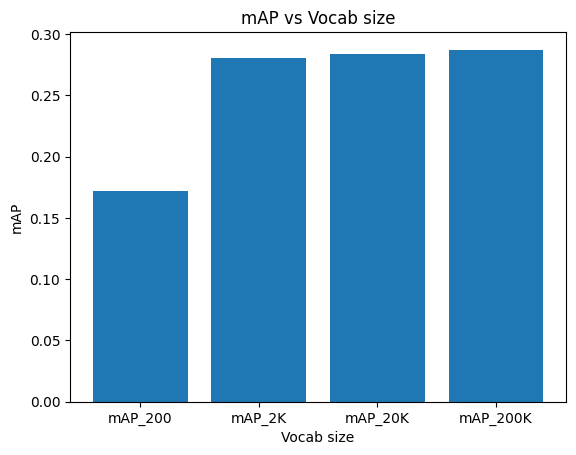

In [ ]:
# Data for the bar chart
map_scores = [mAP_200, mAP_2K, mAP_20K, mAP_200K]
labels = ['mAP_200', 'mAP_2K', 'mAP_20K', 'mAP_200K']

plot_chart(map_scores, labels, "mAP vs Vocab size", "Vocab size", "mAP")

**Q14**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

In [ ]:
print('training time 200: %.5f' % train_time_200)
print('training time 2K: %.5f' % train_time_2K)
print('training time 20K: %.5f' % train_time_20K)
print('training time 200K: %.5f' % train_time_200K)

training time 200: 0.17039
training time 2K: 0.40582
training time 20K: 0.65878
training time 200K: 5.62727


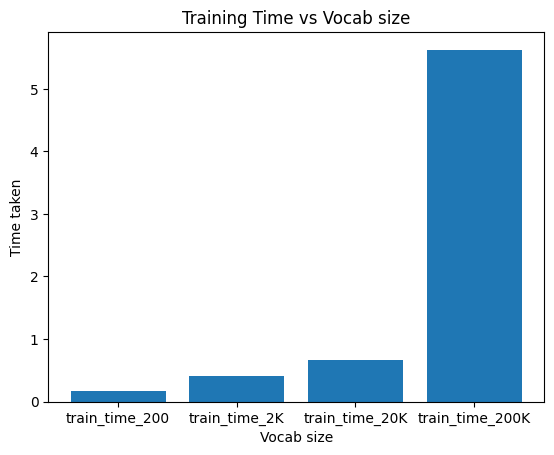

In [ ]:
# Data for the bar chart
time_scores = [train_time_200, train_time_2K, train_time_20K, train_time_200K]
labels = ['train_time_200', 'train_time_2K', 'train_time_20K', 'train_time_200K']

plot_chart(time_scores, labels, "Training Time vs Vocab size", "Vocab size", "Time taken")

In [ ]:
# Initialize a variable to store the total time taken
total_time_200 = 0
total_time_2K = 0
total_time_20K = 0
total_time_200K = 0
# Define the number of queries to run
num_queries = 10

# Loop through the queries
for i in range(num_queries):
    # Time how long the search takes
    start_time_200 = time.time()
    results_200 = index_200.search_image(query_desc[i])
    end_time_200 = time.time()

    start_time_2K = time.time()
    results_2K = index_2K.search_image(query_desc[i])
    end_time_2K = time.time()

    start_time_20K = time.time()
    results_20K = index_20K.search_image(query_desc[i])
    end_time_20K = time.time()

    start_time_200K = time.time()
    results_200K = index_200K.search_image(query_desc[i])
    end_time_200K = time.time()

    # Add the time taken to the total
    total_time_200 += (end_time_200 - start_time_200)
    total_time_2K += (end_time_2K - start_time_2K)
    total_time_20K += (end_time_20K - start_time_20K)
    total_time_200K += (end_time_200K - start_time_200K)

# Compute the average time taken
avg_time_200 = total_time_200 / num_queries
avg_time_2K = total_time_2K / num_queries
avg_time_20K = total_time_20K / num_queries
avg_time_200K = total_time_200K / num_queries

print("avg_time_200: {:.3f} seconds".format(avg_time_200))
print("avg_time_2K: {:.3f} seconds".format(avg_time_2K))
print("avg_time_20K: {:.3f} seconds".format(avg_time_20K))
print("avg_time_200K: {:.3f} seconds".format(avg_time_200K))

avg_time_200: 0.015 seconds
avg_time_2K: 0.020 seconds
avg_time_20K: 0.036 seconds
avg_time_200K: 0.099 seconds


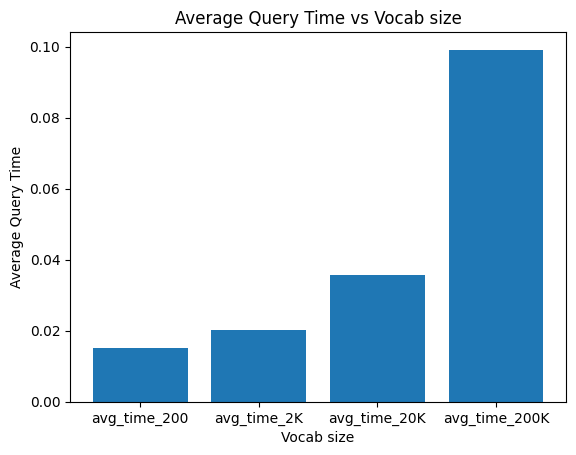

In [ ]:
# Data for the bar chart
time_scores = [avg_time_200, avg_time_2K, avg_time_20K, avg_time_200K]
labels = ['avg_time_200', 'avg_time_2K', 'avg_time_20K', 'avg_time_200K']

plot_chart(time_scores, labels, "Average Query Time vs Vocab size", "Vocab size", "Average Query Time")

**Q15**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q16:** How does TF-IDF affect the performance? Better or worse? Does this make sense?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A2.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A2/Image_Indexing.ipynb'
zf.write('Image_Indexing.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A2.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://uibdigital.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands